In [160]:
import numpy as np
import matplotlib.pyplot as plt 
from numba import jit, njit, vectorize
import time
from IPython.core.debugger import set_trace

## Defining functions that we need:

In [292]:
#Trial energy 1
def TrialEnergy1(alpha,omega,r1,r2):
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@vectorize#By far the quickest of the three for vectors
def TrialEnergy1Vec(alpha,omega,r1,r2):
    #r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    #r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return 0.5*omega**2*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

@jit(nopython=True)
def TrialEnergyJIT(alpha,omega,r1,r2):
    return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha

#Athuga betur hvernig ég á að díla við að deila með núlli þegar Coulomb víxlverkun til staðar
@jit(nopython=True)
def TrialEnergyJITwithCoulomb(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    if abs(r_12) <= 1e-8:
        return 0
    else:
        return 0.5*(omega**2)*(r1**2 + r2**2)*(1 - alpha**2) + 3*omega*alpha + 1/r_12
    
#Trial energy for the seconds trial wave function
@jit(nopython=True)
def TrialEnergy2JIT(alpha,beta,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    TrialEnergy1 = TrialEnergyJITwithCoulomb(alpha,omega,x1,y1,z1,x2,y2,z2)
    if abs(r_12) <= 1e-8:
        return 0
    else:
        TrialEnergy2Partial = (1/(2*(1+beta*r_12)**2))*(alpha*omega*r_12 - (1/2*(1+beta*r_12)**2) - 2/r_12 + (2*beta/(1+beta*r_12)))
        return TrialEnergy1 + TrialEnergy2Partial
    

@jit
def TrialWaveFunction1(alpha,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    return np.exp(-alpha*omega*(r1**2 + r2**2)/2)

@jit
def TrialWaveFunction2(alpha,beta,omega,x1,y1,z1,x2,y2,z2):
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)
    if (beta*r_12 < -1+1e-10) and (beta*r_12 > -1-1e-10):#So that not division by zero
        return 0
    else:
        return np.exp(-alpha*omega*(r1**2 + r2**2)/2)*np.exp(r_12/(2*(1 + beta*r_12)))

In [228]:
alpha = 1
beta = 0
trialEnergyTemp = TrialEnergyJIT(alpha,1,0,0)
print(trialEnergyTemp)
trialEnergyTemp = TrialEnergyJITwithCoulomb(alpha,1,1e-7,0,0,0,0,0)
print(trialEnergyTemp)
x1 = 0
y1 = 0
z1 = 0
x2 = 0
y2 = 0
z2 = 1
trialEnergyTemp = TrialEnergyJITwithCoulomb(alpha,1,x1,y1,z1,z2,y2,z2)
print(trialEnergyTemp)
trialEnergyTemp1 = TrialEnergy2JIT(alpha,beta,1,x1,y1,z1,z2,y2,z2)
print(trialEnergyTemp1)

3.0
10000003.0
3.7071067811865475
3.4571067811865475


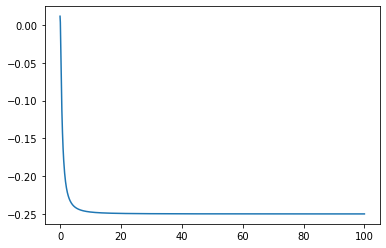

In [225]:
#Trying to plot just the addon due to trial wave function 2 to the trial energy
alpha = 1
omega = 1
r_12 = 1.7
beta = np.linspace(0,100,1000)
TrialEnergy2Partial = (1/(2*(1+beta*r_12)**2))*(alpha*omega*r_12 - (1/2*(1+beta*r_12)**2) - 2/r_12 + (2*beta/(1+beta*r_12)))
#plotting
fig0,ax0 = plt.subplots()
ax0.plot(beta,TrialEnergy2Partial)

## Monte Carlo and Metropolis algo:

In [230]:
#Probability ratio
@jit
def ProbRatio(Rold,Rnew,alpha,omega):#Rold and Rnew as an array
    new = TrialWaveFunction1(alpha,omega,Rnew[0],Rnew[1],Rnew[2],Rnew[3],Rnew[4],Rnew[5])
    new = new**2
    old = TrialWaveFunction1(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
    old = old**2
    return new/old

#Probability ratio for the second trial wave function
@jit
def ProbRatio2(Rold,Rnew,alpha,beta,omega):#Rold and Rnew as an array
    new = TrialWaveFunction2(alpha,beta,omega,Rnew[0],Rnew[1],Rnew[2],Rnew[3],Rnew[4],Rnew[5])
    new = new**2
    old = TrialWaveFunction2(alpha,beta,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
    old = old**2
    return new/old

#Metropolis part for the first trial wave function
@jit
def Metropolis(Rold,Rnew,alpha,omega):
    Acceptance = False
    probRatio = ProbRatio(Rold,Rnew,alpha,omega)
    if probRatio > 1:
        Acceptance = True
    elif np.random.random() <= probRatio:
        Acceptance = True
    else:
        Acceptance = False
    return Acceptance

#Metropolis test for the second trial wave function
@jit
def Metropolis2(Rold,Rnew,alpha,beta,omega):
    Acceptance = False
    probRatio = ProbRatio2(Rold,Rnew,alpha,beta,omega)
    if probRatio > 1:
        Acceptance = True
    elif np.random.random() <= probRatio:
        Acceptance = True
    else:
        Acceptance = False
    return Acceptance

In [7]:
R1 = np.array([1,1,1,1,1,1])
R2 = np.array([2,2,2,2,2,2])
alpha = 1
omega = 1
print(Metropolis(R1,R2,alpha,omega))

a = np.array([1,2,3])
print(a+1)

False
[2 3 4]


**First Monte Carlo with trial wave function 1 and without Coulomb interaction:**

In [231]:
#Monte Carlo part
@jit(nopython=True)
def MonteCarlo(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = 0
    EnergySquared = 0
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = np.random.random() - 0.5#creating random number on [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            EnergyTemp = TrialEnergyJIT(alpha,omega,r1,r2)
            Energy += EnergyTemp
            EnergySquared += EnergyTemp**2

    #End of MC loop
    #Analysis of relevant parameters
    AverageEnergy = Energy/MCCycles/6
    AverageEnergySquared = EnergySquared/MCCycles/6
    Variance = AverageEnergySquared - AverageEnergy**2
    
    return AverageEnergy, CounterAccept/6, Variance

**Then MC for trial wave function 1 with Coulomb interaction: ATH LAGA ÞETTA FALL!!**

In [232]:
#Monte Carlo part
@jit(nopython=True)
def MonteCarloCoulomb(MCCycles,omega,alpha,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = 0
    EnergySquared = 0
    ElectronDistance = 0
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = np.random.random() - 0.5#creating random number on [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis(Rold,Rnew,alpha,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            EnergyTemp = TrialEnergyJITwithCoulomb(alpha,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
            if np.isnan(EnergyTemp):
                print("Error, the Energy is nan, cycle numner:",i,l)
                break
            Energy += EnergyTemp
            EnergySquared += EnergyTemp**2
            #Updating the expectationValue of the distance between the two electrons
            ElectronDistance += np.sqrt((Rold[0]-Rold[3])**2 + (Rold[1]-Rold[4])**2 + (Rold[2]-Rold[5])**2)
            

    #End of MC loop
    #Analysis of relevant parameters
    AverageEnergy = Energy/MCCycles/6
    AverageEnergySquared = EnergySquared/MCCycles/6
    Variance = AverageEnergySquared - AverageEnergy**2
    ElectronDistanceAverage = ElectronDistance/MCCycles/6
    
    return AverageEnergy, int(CounterAccept/6), Variance, ElectronDistanceAverage

**Then Monte Carlo for the second trial wave function:**

In [233]:
@jit(nopython=True)
def MonteCarlo2(MCCycles,omega,alpha,beta,stepsize):
    #initalizing position randomly according to exponetial distribution
    x1 = np.random.exponential()
    y1 = np.random.exponential()
    z1 = np.random.exponential()
    x2 = np.random.exponential()
    y2 = np.random.exponential()
    z2 = np.random.exponential()
    r1 = np.sqrt(x1**2 + y1**2 + z1**2)
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    Rold = np.array([x1,y1,z1,x2,y2,z2])
    Energy = 0
    EnergySquared = 0
    ElectronDistance = 0
    #Step size for proposed steps
    DeltaR = stepsize
    #Counter for how many steps are accepted
    CounterAccept = 0
    #looping over MC cycles
    for i in range(MCCycles):
        #looping over each position, in total 6
        for l in range(6):
            randnum = np.random.random() - 0.5#creating random number on [-0.5,0.5]
            Rnew = np.copy(Rold)
            Rnew[l] = Rold[l] + randnum*DeltaR#The proposed move for each coordinate at a time
            #Metropolis test
            Acceptance = Metropolis2(Rold,Rnew,alpha,beta,omega)
            if Acceptance:#Moving the coordinates if the move is accepted
                Rold = Rnew
                CounterAccept += 1
            r1 = np.sqrt(Rold[0]**2 + Rold[1]**2 + Rold[2]**2)
            r2 = np.sqrt(Rold[3]**2 + Rold[4]**2 + Rold[5]**2)
            EnergyTemp = TrialEnergy2JIT(alpha,beta,omega,Rold[0],Rold[1],Rold[2],Rold[3],Rold[4],Rold[5])
            if np.isnan(EnergyTemp):
                print("Error, the Energy is nan, cycle numner:",i,l)
                break
            Energy += EnergyTemp
            EnergySquared += EnergyTemp**2
            #Updating the expectationValue of the distance between the two electrons
            ElectronDistance += np.sqrt((Rold[0]-Rold[3])**2 + (Rold[1]-Rold[4])**2 + (Rold[2]-Rold[5])**2)
            

    #End of MC loop
    #Analysis of relevant parameters
    AverageEnergy = Energy/MCCycles/6
    AverageEnergySquared = EnergySquared/MCCycles/6
    Variance = AverageEnergySquared - AverageEnergy**2
    ElectronDistanceAverage = ElectronDistance/MCCycles/6
    
    return AverageEnergy, int(CounterAccept/6), Variance, ElectronDistanceAverage

## Trial of the MC calculations:

71829.83333333333 6.873207123021892
64617.333333333336 1.7165072822441534
59276.166666666664 0.39797493719109056
55022.0 0.03354867630279479
53197.833333333336 0.0
49920.0 0.10154226551147616
47235.0 0.35224880418301474
44840.0 0.7532466050509008
42639.0 1.147563402354324
40868.166666666664 1.695743535772733


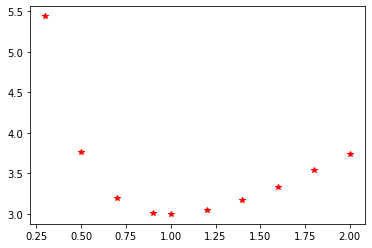

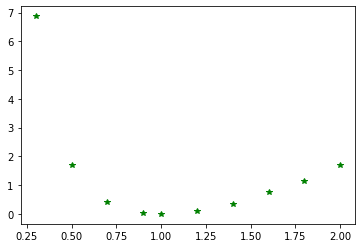

In [21]:
alpha = [0.3,0.5,0.7,0.9,1,1.2,1.4,1.6,1.8,2.0]
fig, ax = plt.subplots()
fig0, ax0 = plt.subplots()
for alphaTemp in alpha:
    Energy, Counter, Variance = MonteCarlo(100000,1,alphaTemp,3.8)
    print(Counter,Variance)
    ax.plot(alphaTemp,Energy,'r*')
    ax0.plot(alphaTemp,Variance,'g*')

**Device a way to find the optimal step length for each alpha so that acceptance rate is around 50%**

**Algorithm that takes care of finding the step size such that 50 \% acceptance rate in a brute force way:**

In [339]:
def FindStepsize(stepsize,alpha,omega):
    MCCycles = 10000
    M = len(alpha)
    StepSize = np.zeros(M)
    counter = 0
    for i in alpha:
        StepTemp = []
        for l in stepsize:
            Energy, Counter, Variance = MonteCarlo(10000,omega,i,l)
            if (Counter >= 4900) and (Counter <= 5100):
                StepTemp.append(l)
        StepSize[counter] = np.median(StepTemp)
        counter += 1
        
    return StepSize

def FindStepsize2(stepsize,alpha,beta,omega):
    MCCycles = 10000
    M = len(beta)
    StepSize = np.zeros(M)
    counter = 0
    for i in beta:
        StepTemp = []
        for l in stepsize:
            Energy, Counter, Variance, ElectronDistance = MonteCarlo2(10000,omega,alpha,i,l)
            if (Counter >= 4900) and (Counter <= 5100):
                StepTemp.append(l)
        StepSize[counter] = np.median(StepTemp)
        counter += 1
        
    return StepSize

#Function that finds the minimal energy in terms of either alpha or beta
#as well as finding the electron distance at that minimum
def FindMinimalEnergy(EnergyTotal,ElectronDistance,alpha,beta,VarChoice):
    #Variable VarChoice decides which variable we are trying to find a minimum at, alpha or beta
    MinimalEnergy = np.min(EnergyTotal)
    MinimalEnergyIndex = np.where(EnergyTotal == MinimalEnergy)[0][0]#Index for minimal energy
    if VarChoice == "alpha":
        alphaMinimal = alpha[MinimalEnergyIndex]
        electronDistanceMinimalEnergy = ElectronDistance[MinimalEnergyIndex]
        return MinimalEnergy, electronDistanceMinimalEnergy, alphaMinimal
    elif VarChoice == "beta":
        betaMinimal = beta[MinimalEnergyIndex]
        electronDistanceMinimalEnergy = ElectronDistance[MinimalEnergyIndex]
        return MinimalEnergy, electronDistanceMinimalEnergy, betaMinimal
    else:
        assert("Please state wheter to find minimal with regards to beta or alpha")

In [259]:
#Trial
stepsize = np.arange(0,10,0.05)
alpha = np.arange(0.2,2,0.2)
print(alpha)
StepSize = FindStepsize(stepsize,alpha)
#Trial for second wave function
beta = np.arange(0.2,2,0.2)
StepSize2 = FindStepsize2(stepsize,0.85,beta)
print(StepSize2)

[0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8]
[4.775 4.7   4.625 4.625 4.6   4.6   4.575 4.6   4.575]


In [28]:
print(StepSize)

[9.275 6.55  5.35  4.65  4.175 3.8   3.525 3.275 3.1  ]


500973.6666666667
501185.5
501444.8333333333
499937.0
498667.0
499560.5
498734.3333333333
501365.5
500609.1666666667


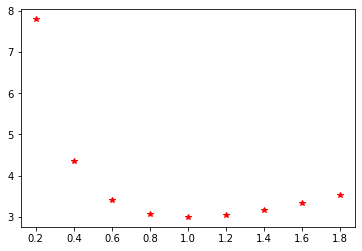

In [30]:
fig3, ax3 = plt.subplots()
for i in range(len(alpha)):
    stepTemp = StepSize[i]
    alphaTemp = alpha[i]
    Energy, Counter, Variance = MonteCarlo(1000000,1,alphaTemp,stepTemp)
    print(Counter)
    ax3.plot(alphaTemp,Energy,'r*')

# 5.c)

**First let's check our calculations without the Coulomb potential and see if we obtain the exact answer:**

499003.6666666667 7.808273769298527 17.30281358301375
500850.1666666667 6.3743725062164005 10.546490184884497
498738.1666666667 5.454235946363128 6.891218626121301
499033.1666666667 4.807042411954534 4.713471991573453
502695.1666666667 4.349285505398034 3.306954137387166
500001.5 4.009627168945303 2.3700699462089254
497457.8333333333 3.748868776324519 1.6911840111990983
499067.8333333333 3.5533093004490053 1.2094331600415877
501773.8333333333 3.400486864384481 0.8544809738285792
498737.0 3.2803623215217126 0.5883744581380945
499810.1666666667 3.1948408479406862 0.3980819055863325
500148.0 3.125737871082341 0.2563621833028993
497655.8333333333 3.07385563789037 0.15143500049932435
500766.8333333333 3.040080455555834 0.07997793861683178
498478.1666666667 3.0163254433959263 0.033414126948146716
495188.6666666667 3.0040147354676363 0.007897449238566168
501012.3333333333 3.0 0.0
503093.1666666667 3.0037044500634242 0.007128248534591819
496846.3333333333 3.013420307074274 0.027462068161414166

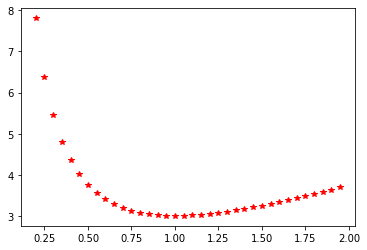

In [71]:
#Monte Carlo calculations for the first trial wave function for more number of different alpha
#first finding the optimal step size for each value of alpha
alpha1 = np.arange(0.2,2,0.05)
stepsize1 = np.arange(0,10,0.05)
StepSize1 = FindStepsize(stepsize1,alpha1)
#Then doing calculation for each alpha
fig4, ax4 = plt.subplots()
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance = MonteCarlo(1000000,1,alphaTemp,stepTemp)
    print(Counter,Energy,Variance)
    ax4.plot(alphaTemp,Energy,'r*')
end = time.time()
print("Measurement took in seconds:",end-start)

## Then we do the calculations with Coulomb interaction for both trial wave functions. Basing the optimization of paramater $\beta$ on the initial extremum in $\alpha$. We take measurements for three different value of $\omega$, $\omega \in \{0.01,0.5,1\}$

# First with $\omega = 1$:

In [282]:
omega = 1
EnergyTotal = np.zeros(len(alpha1))
CounterTotal = np.zeros(len(alpha1))
VarianceTotal = np.zeros(len(alpha1))
ElectronDistanceTotal = np.zeros(len(alpha1))
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance, ElectronDistance = MonteCarloCoulomb(int(1e6),omega,alphaTemp,stepTemp)
    EnergyTotal[i] = Energy
    CounterTotal[i] = Counter
    VarianceTotal[i] = Variance
    ElectronDistanceTotal[i] = ElectronDistance
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 41.17655563354492


In [303]:
#Finding the lowest energy
MinimalEnergy, electDistMinimalEnergy, alphaMinimal = FindMinimalEnergy(EnergyTotal,ElectronDistanceTotal,alpha1,1,"alpha")
print(MinimalEnergy)
print(alphaMinimal,electDistMinimalEnergy)

3.774100014850241
0.8999999999999999 1.6810623394492132


**Plotting:**

Text(0.5, 0, '$\\alpha$')

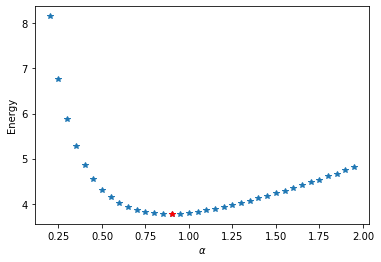

In [304]:
#Energy as a function of variational paramater alpha
fig5_1,ax5_1 = plt.subplots()
ax5_1.plot(alpha1,EnergyTotal,'*')
ax5_1.plot(alphaMinimal,MinimalEnergy,'r*')
ax5_1.set_ylabel("Energy")
ax5_1.set_xlabel(r"$\alpha$")

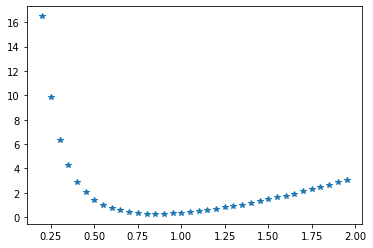

In [286]:
#Variance as a function of variational parameter alpha
fig5_2,ax5_2 = plt.subplots()
ax5_2.plot(alpha1,VarianceTotal,'*')

**Then analysis for the second trial wave function using the optimal $\alpha$ obtained:**

In [319]:
#Setting up range in beta
temp = np.arange(0.4,1.4,0.02)
beta1 = np.arange(0.02,3,0.2)
beta1 = np.concatenate((temp,beta1),axis=0)
beta1 = np.sort(beta1)
print(beta1)

[0.02 0.22 0.4  0.42 0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58 0.6
 0.62 0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36
 1.38 1.42 1.62 1.82 2.02 2.22 2.42 2.62 2.82]


In [320]:
#Finding the right stepsize
stepsize = np.arange(1,10,0.2)
StepSize2 = FindStepsize2(stepsize,0.9,beta1,1)
print(StepSize2)

C:\Users\lenovo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lenovo\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[4.9 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.5 4.6 4.5 4.4 4.5
 4.5 4.5 nan 4.5 4.5 4.6 4.4 4.5 4.5 4.5 4.4 4.5 4.5 4.5 4.4 4.4 4.4 4.4
 4.4 4.5 4.4 4.4 4.4 4.4 4.5 4.4 4.4 4.4 4.4 4.4 4.4 4.4 4.4 4.4 4.4 4.4
 4.4 4.5 4.4 4.4 4.4 4.4 4.4 4.4 4.4 4.4 4.4]


In [321]:
omega = 1
alpha2 = 0.9
EnergyTotal3 = np.zeros(len(beta1))
CounterTotal3 = np.zeros(len(beta1))
VarianceTotal3 = np.zeros(len(beta1))
ElectronDistanceTotal3 = np.zeros(len(beta1))
start = time.time()
for i in range(len(beta1)):
    Energy, Counter, Variance, ElectronDistance = MonteCarlo2(int(5e6),omega,alpha2,beta1[i],4.5)
    EnergyTotal3[i] = Energy
    CounterTotal3[i] = Counter
    VarianceTotal3[i] = Variance
    ElectronDistanceTotal3[i] = ElectronDistance
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 501.1616015434265


In [322]:
#Finding the minimal energy
MinimalEnergy1, electDistMinimalEnergy1, betaMinimal1 = FindMinimalEnergy(EnergyTotal3,ElectronDistanceTotal3,alpha2,beta1,"beta")
print(MinimalEnergy1)
print(betaMinimal1,electDistMinimalEnergy1)

3.504701579845564
1.0200000000000005 1.7539313488195472


Text(0, 0.5, 'Energy')

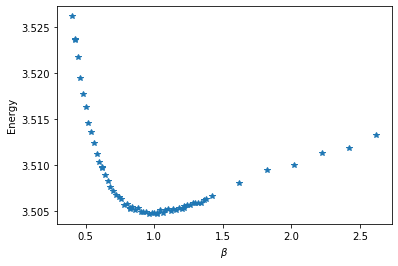

In [323]:
#plotting Energy as a function of Beta
fig5_3,ax5_3 = plt.subplots()
ax5_3.plot(beta1[2:-1],EnergyTotal3[2:-1],'*')
ax5_3.set_xlabel(r"$\beta$")
ax5_3.set_ylabel("Energy")

[0.24922616 0.03869588 0.02099428 0.02091231 0.02096203 0.02116383
 0.02142944 0.021833   0.02242276 0.02306216 0.02394205 0.02479412
 0.02569541 0.02673644 0.02784827 0.02784504 0.02891976 0.03009876
 0.03124497 0.03254425 0.03376159 0.03510312 0.036432   0.03766375
 0.039041   0.04039757 0.04036805 0.04184386 0.0431034  0.04460172
 0.04578164 0.04731013 0.04857969 0.04994821 0.05129458 0.05268294
 0.05404517 0.05402182 0.05559778 0.05673996 0.05823485 0.05957438
 0.06068161 0.06206089 0.06341146 0.06478579 0.06602165 0.0673077
 0.06744659 0.06871759 0.06994969 0.07112317 0.07254583 0.07365676
 0.0747061  0.07601426 0.07725137 0.07973424 0.09111754 0.10162934
 0.11072548 0.11925722 0.1264013  0.13439763 0.14077379]


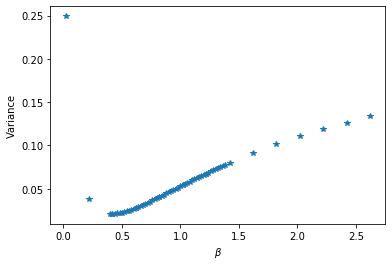

In [324]:
#plotting Variance in Energy as a function of Beta
fig5_4,ax5_4 = plt.subplots()
ax5_4.plot(beta1[0:-1],VarianceTotal3[0:-1],'*')
ax5_4.set_xlabel(r"$\beta$")
ax5_4.set_ylabel("Variance")
print(VarianceTotal3)

# Then with $\omega = 0.01$:

In [325]:
omega = 0.01
EnergyTotal1 = np.zeros(len(alpha1))
CounterTotal1= np.zeros(len(alpha1))
VarianceTotal1 = np.zeros(len(alpha1))
ElectronDistanceTotal1 = np.zeros(len(alpha1))
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance, ElectronDistance = MonteCarloCoulomb(1000000,omega,alphaTemp,stepTemp)
    EnergyTotal1[i] = Energy
    CounterTotal1[i] = Counter
    VarianceTotal1[i] = Variance
    ElectronDistanceTotal1[i] = ElectronDistance
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 46.25438451766968


In [332]:
#Finding the lowest energy
MinimalEnergy1, electDistMinimalEnergy1, alphaMinimal1 = FindMinimalEnergy(EnergyTotal1,ElectronDistanceTotal1,alpha1,1,"alpha")
print("The minimal energy is:",MinimalEnergy1)
print("The minimal energy is at alpha =",alphaMinimal1)
print("There the distance between electrons is:",electDistMinimalEnergy1)

The minimal energy is: 0.09397719936947845
The minimal energy is at alpha = 0.44999999999999996
There the distance between electrons is: 23.74278954979697


**Plotting:**

Text(0.5, 0, '$\\alpha$')

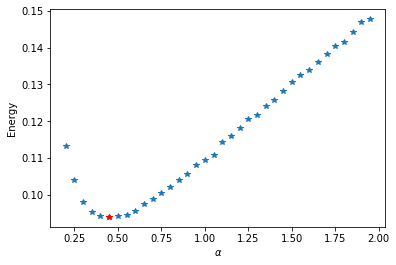

In [328]:
#Energy as a function of variational paramater alpha
fig6_1,ax6_1 = plt.subplots()
ax6_1.plot(alpha1,EnergyTotal1,'*')
ax6_1.plot(alphaMinimal1,MinimalEnergy1,'r*')
ax6_1.set_ylabel("Energy")
ax6_1.set_xlabel(r"$\alpha$")

Text(0.5, 0, '$\\alpha$')

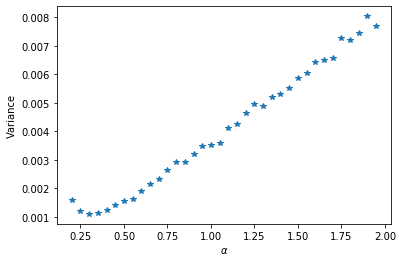

In [335]:
#Variance as a function of variational parameter alpha
fig6_2,ax6_2 = plt.subplots()
ax6_2.plot(alpha1,VarianceTotal1,'*')
ax6_2.set_ylabel("Variance")
ax6_2.set_xlabel(r"$\alpha$")

**Then analysis for the second trial wave function using the optimal $\alpha$ obtained:**

In [352]:
#Setting up range in beta
temp = np.arange(0.01,0.4,0.02)
beta1 = np.arange(0.02,3,0.2)
beta1 = np.concatenate((temp,beta1),axis=0)
beta2 = np.sort(beta1)
print(beta2)

[0.01 0.02 0.03 0.05 0.07 0.09 0.11 0.13 0.15 0.17 0.19 0.21 0.22 0.23
 0.25 0.27 0.29 0.31 0.33 0.35 0.37 0.39 0.42 0.62 0.82 1.02 1.22 1.42
 1.62 1.82 2.02 2.22 2.42 2.62 2.82]


In [342]:
#Finding the right stepsize
stepsize = np.arange(20,40,0.2)
StepSize2 = FindStepsize2(stepsize,0.45,beta1,0.01)
print(StepSize2)

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan]


In [353]:
omega = 0.01
alpha2 = 0.45
EnergyTotal4 = np.zeros(len(beta2))
CounterTotal4 = np.zeros(len(beta2))
VarianceTotal4 = np.zeros(len(beta2))
ElectronDistanceTotal4 = np.zeros(len(beta2))
start = time.time()
for i in range(len(beta2)):
    Energy, Counter, Variance, ElectronDistance = MonteCarlo2(int(1e6),omega,alpha2,beta2[i],4.5)
    EnergyTotal4[i] = Energy
    CounterTotal4[i] = Counter
    VarianceTotal4[i] = Variance
    ElectronDistanceTotal4[i] = ElectronDistance
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 56.71172046661377


In [354]:
#Finding the minimal energy
MinimalEnergy3, electDistMinimalEnergy3, betaMinimal3 = FindMinimalEnergy(EnergyTotal4,ElectronDistanceTotal4,alpha2,beta2,"beta")
print(MinimalEnergy3)
print(betaMinimal3,electDistMinimalEnergy3)

-0.1632687147365074
0.10999999999999997 30.691367869860528


Text(0, 0.5, 'Energy')

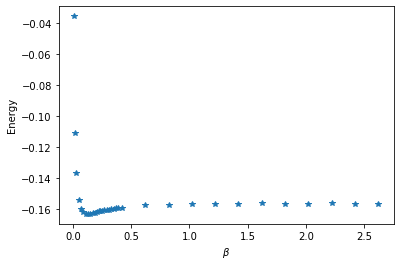

In [355]:
#plotting Energy as a function of Beta
fig6_3,ax6_3 = plt.subplots()
ax6_3.plot(beta2[0:-1],EnergyTotal4[0:-1],'*')
ax6_3.set_xlabel(r"$\beta$")
ax6_3.set_ylabel("Energy")

# Then with $\omega = 0.5$:

In [356]:
omega = 0.5
EnergyTotal5 = np.zeros(len(alpha1))
CounterTotal5 = np.zeros(len(alpha1))
VarianceTotal5 = np.zeros(len(alpha1))
ElectronDistanceTotal5 = np.zeros(len(alpha1))
start = time.time()
for i in range(len(alpha1)):
    stepTemp = StepSize1[i]
    alphaTemp = alpha1[i]
    Energy, Counter, Variance, ElectronDistance = MonteCarloCoulomb(1000000,omega,alphaTemp,stepTemp)
    EnergyTotal5[i] = Energy
    CounterTotal5[i] = Counter
    VarianceTotal5[i] = Variance
    ElectronDistanceTotal5[i] = ElectronDistance
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 47.46701097488403


In [359]:
#Finding the lowest energy
MinimalEnergy5, electDistMinimalEnergy5, alphaMinimal5 = FindMinimalEnergy(EnergyTotal5,ElectronDistanceTotal5,alpha1,1,"alpha")
print("The minimal energy is:",MinimalEnergy5)
print("The minimal energy is at alpha =",alphaMinimal5)
print("There the distance between electrons is:",electDistMinimalEnergy5)

The minimal energy is: 2.0403815130292897
The minimal energy is at alpha = 0.8499999999999999
There the distance between electrons is: 2.4446483621064443


Text(0, 0.5, 'Energy')

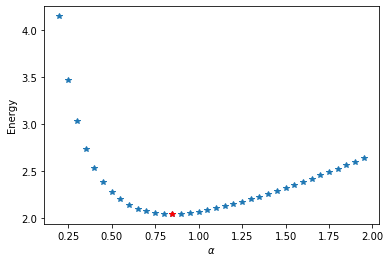

In [364]:
#Energy as a function of variational paramater alpha
fig7, ax7 = plt.subplots()
ax7.plot(alpha1,EnergyTotal5,'*')
ax7.plot(alphaMinimal5,MinimalEnergy5,'r*')
ax7.set_xlabel(r"$\alpha$")
ax7.set_ylabel("Energy")

Text(0.5, 0, '$\\alpha$')

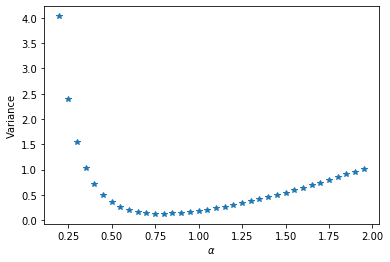

In [365]:
#Variance as a function of variational parameter alpha
fig7_2,ax7_2 = plt.subplots()
ax7_2.plot(alpha1,VarianceTotal5,'*')
ax7_2.set_ylabel("Variance")
ax7_2.set_xlabel(r"$\alpha$")

**Then for variational parameter $\beta$:**

In [368]:
#Setting up range in beta
temp = np.arange(0.4,1.4,0.02)
beta1 = np.arange(0.02,3,0.2)
beta1 = np.concatenate((temp,beta1),axis=0)
beta3 = np.sort(beta1)
print(beta3)

[0.02 0.22 0.4  0.42 0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58 0.6
 0.62 0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36
 1.38 1.42 1.62 1.82 2.02 2.22 2.42 2.62 2.82]


In [367]:
#Finding the right stepsize
stepsize = np.arange(1,10,0.2)
StepSize3 = FindStepsize2(stepsize,0.85,beta3,1)
print(StepSize3)

[5.  5.1 5.  5.  5.  5.  4.9 4.8 4.8 4.8 4.8 4.8 4.8 4.8 4.8 4.8 4.8 4.8
 4.8 4.7 4.7 4.7 4.7 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.6 4.5 4.6]


In [369]:
omega = 0.5
alpha2 = 0.85
EnergyTotal6 = np.zeros(len(beta3))
CounterTotal6 = np.zeros(len(beta3))
VarianceTotal6 = np.zeros(len(beta3))
ElectronDistanceTotal6 = np.zeros(len(beta3))
start = time.time()
for i in range(len(beta3)):
    Energy, Counter, Variance, ElectronDistance = MonteCarlo2(int(1e6),omega,alpha2,beta3[i],4.6)
    EnergyTotal6[i] = Energy
    CounterTotal6[i] = Counter
    VarianceTotal6[i] = Variance
    ElectronDistanceTotal6[i] = ElectronDistance
end = time.time()
print("measurement took in seconds:",end-start)

measurement took in seconds: 97.71060419082642


In [371]:
#Finding the minimal energy
MinimalEnergy6, electDistMinimalEnergy6, betaMinimal6 = FindMinimalEnergy(EnergyTotal6,ElectronDistanceTotal6,alpha2,beta3,"beta")
print("The minimum in energy is :",MinimalEnergy6)
print("Beta at that minimum is:",betaMinimal6)
print("The electron distance at the minimum is",electDistMinimalEnergy6)

The minimum in energy is : 1.7730882508663621
Beta at that minimum is: 0.8000000000000004
The electron distance at the minimum is 2.5741257785877476


Text(0, 0.5, 'Energy')

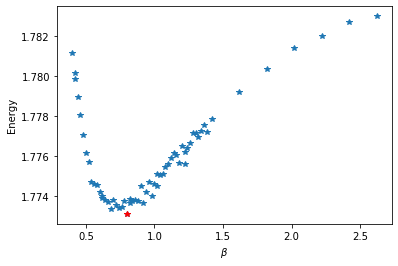

In [379]:
#plotting Energy as a function of Beta
fig7_3,ax7_3 = plt.subplots()
ax7_3.plot(beta3[2:-1],EnergyTotal6[2:-1],'*')
ax7_3.plot(betaMinimal6,MinimalEnergy6,'r*')
ax7_3.set_xlabel(r"$\beta$")
ax7_3.set_ylabel("Energy")